In [1]:
import importlib
import io
import os
import sys
import csv
import gzip
import time
import json
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *

pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

/gpfs3/well/band/users/rbx225/GAMCC


# Plot sample metrics

Text(0, 0.5, 'Duplication Rate')

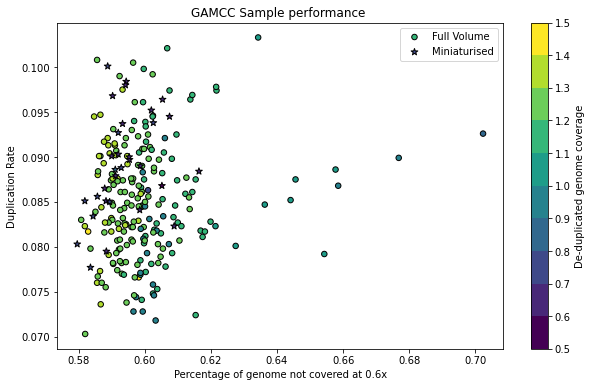

In [2]:
# util
metrics = pd.read_csv('results/metrics.csv')
fv = metrics[~metrics['Sample_Name'].str.contains('mini')]
mini = metrics[metrics['Sample_Name'].str.contains('mini')]

title = 'GAMCC Sample performance '

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
plt.grid(False)

cmap = plt.get_cmap('viridis')
magnitude = 10
bounds = np.linspace(0.5, 1.5, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.scatter(fv['Subsample_Uncoverage_0.6x'], fv['Dup_Rate'], c = fv['Coverage'], edgecolor='black', cmap=cmap, norm=norm, s = 30, marker = 'o', label = 'Full Volume')
im = plt.scatter(mini['Subsample_Uncoverage_0.6x'], mini['Dup_Rate'], c = mini['Coverage'], edgecolor='black', cmap=cmap, norm=norm, s = 50, marker = '*', label = 'Miniaturised')
plt.colorbar(im, boundaries=bounds, ticks = bounds, label='De-duplicated genome coverage')

plt.xlabel('Percentage of genome not covered at 0.6x')
plt.title(title)
plt.legend()
plt.ylabel('Duplication Rate')
# ax = plt.gca()
# ax.grid()

# PCA comparison

In [21]:
ethnic = pd.read_csv('data/metadata/ethnic_group.csv')
ethnic = ethnic.rename(columns = {'Chip_Name': 'FID'})
sl = pd.read_csv(SAMPLE_LINKER_FILE)
sl = sl[~sl['Sample_Name'].str.contains('mini')]
sl = {k:v for k,v in zip(sl['Sample_Name'], sl['Chip_Name'])}
PCchip = pd.read_csv('results/chip/qc/PCs/PCs.eigenvec', sep = ' ', header = None, names = ['FID', 'IID'] + ['PC' + str(i) for i in range(1,11)])
PCchip = PCchip.drop(columns = 'IID')
PClc = pd.read_csv('results/wip_vcfs/oneKG/chip_sites/PCs.eigenvec', sep = ' ', header = None, names = ['FID', 'IID'] + ['PC' + str(i) for i in range(1,11)])
PClc = PClc[~PClc['IID'].str.contains('mini')]
PClc = PClc.drop(columns = 'IID')
lc_to_retain = lcwgsus.find_matching_samples(PCchip['FID'].values, rename_map = sl, lc = 'lc')
PClc = PClc[PClc['FID'].isin(lc_to_retain)]
def recode_names(r, sl = sl):
    r['FID'] = sl[r['FID']]
    return r
PClc = PClc.apply(recode_names, axis = 1)
PCchip = pd.merge(PCchip, ethnic, on = 'FID')
PClc = pd.merge(PClc, ethnic, on = 'FID')

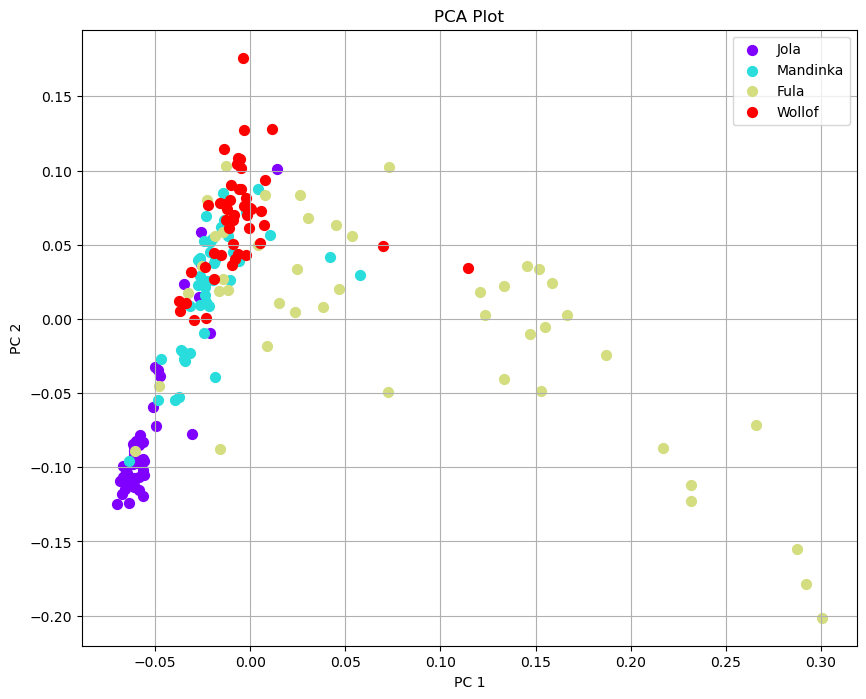

In [22]:
lcwgsus.plot_pc(PClc)

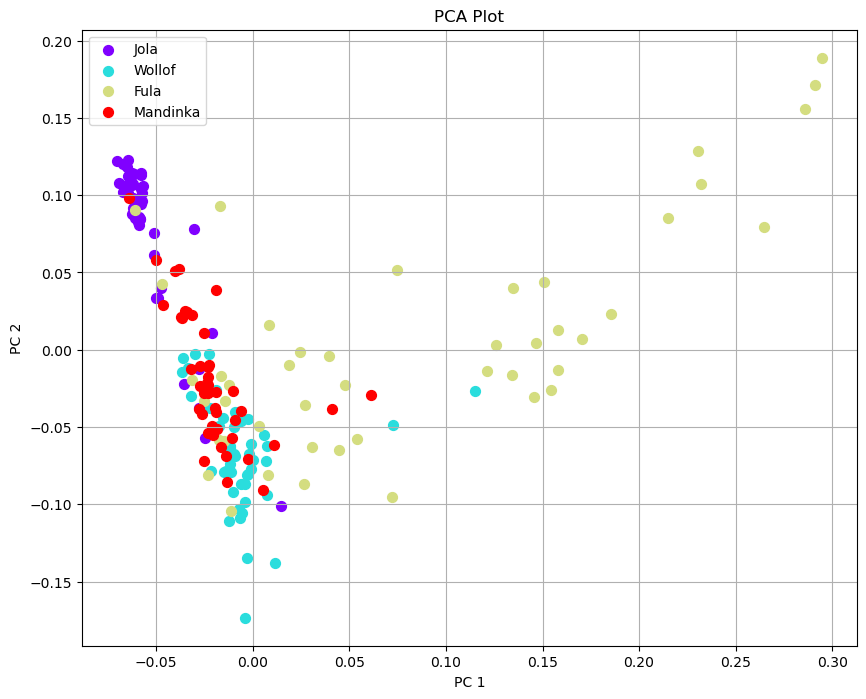

In [23]:
lcwgsus.plot_pc(PCchip)

# Full comparison across runs

In [8]:
configfile = "/well/band/users/rbx225/GAMCC/pipelines/config.json"
with open(configfile, 'r') as file:
    data = json.load(file)
    
imp_dirs = data['imputation_dir']
mini_imp_dirs = data['mini_imputation_dir']
lr_imp_dirs = data['lr_imputation_dir']

for i in imp_dirs + mini_imp_dirs:
    print(i)

/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG--chip--typed/
/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG--chip--typed_high_info/
/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/chip_oneKG--hc--snps_gw/
/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG--hc--snps_gw/
/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/chip_topmed--hc--snps_gw/
/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG_oneKG--hc--snps_gw/
/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG_topmed--hc--snps_gw/
/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG_typed_oneKG--hc--snps_gw/
/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG_typed_topmed--hc--snps_gw/
/well/band/users/rbx225/GAMCC/results/imputation_comparison/fv-mini/fv/lc_oneKG--chip--typed/
/well/band/users/rbx225/GAMCC/resu

In [9]:
impaccs = []
for d in imp_dirs:
    v = pd.read_csv(d + "impacc/all_samples/by_sample/all.v.impacc.tsv", sep = '\t')
    impaccs.append(v)

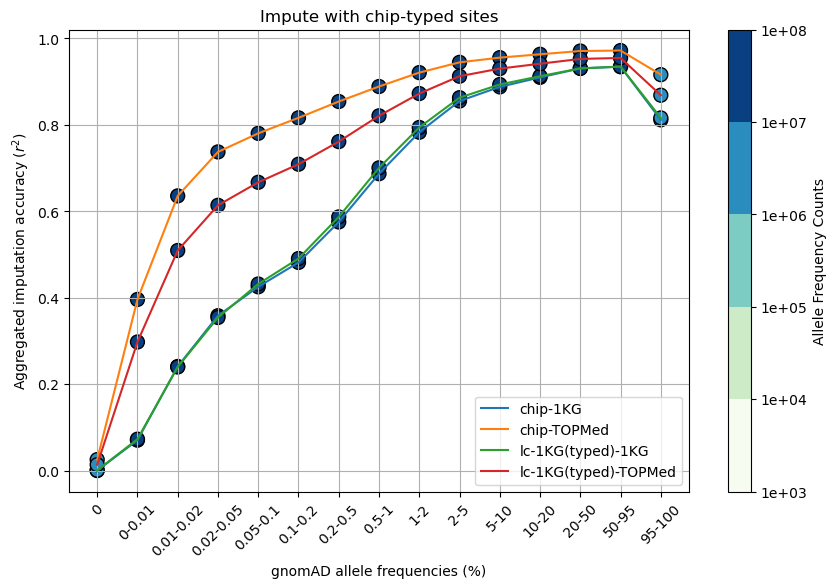

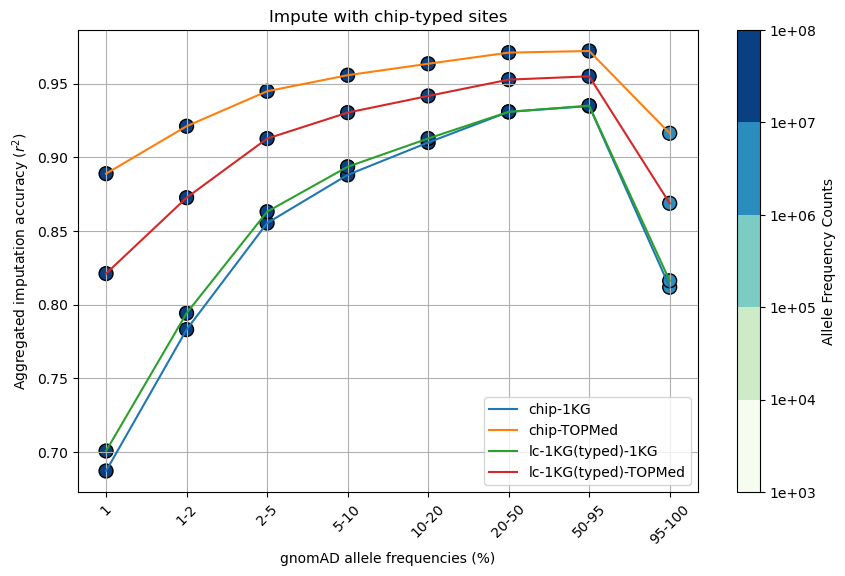

In [24]:
ixs = [2,4,7,8]
dfs = [impaccs[i] for i in ixs]
labels = ['chip-1KG', 'chip-TOPMed', 'lc-1KG(typed)-1KG', 'lc-1KG(typed)-TOPMed']
title = 'Impute with chip-typed sites'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

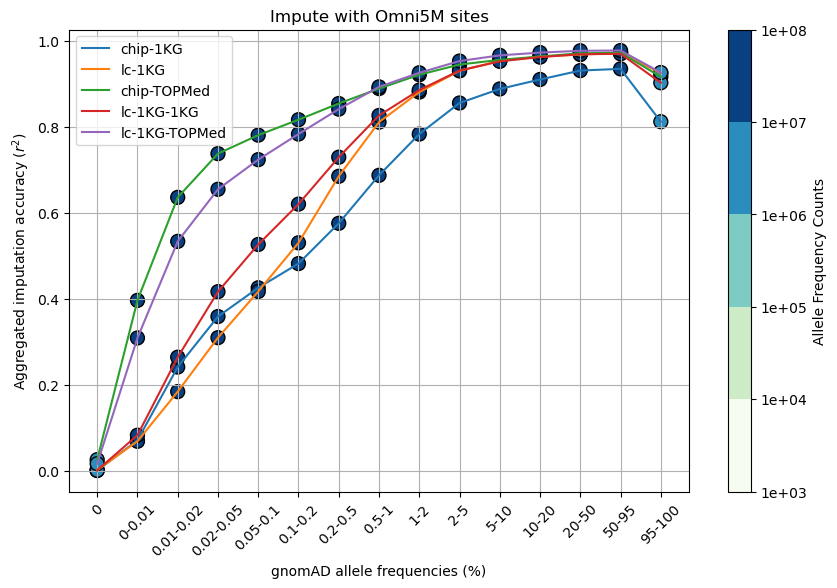

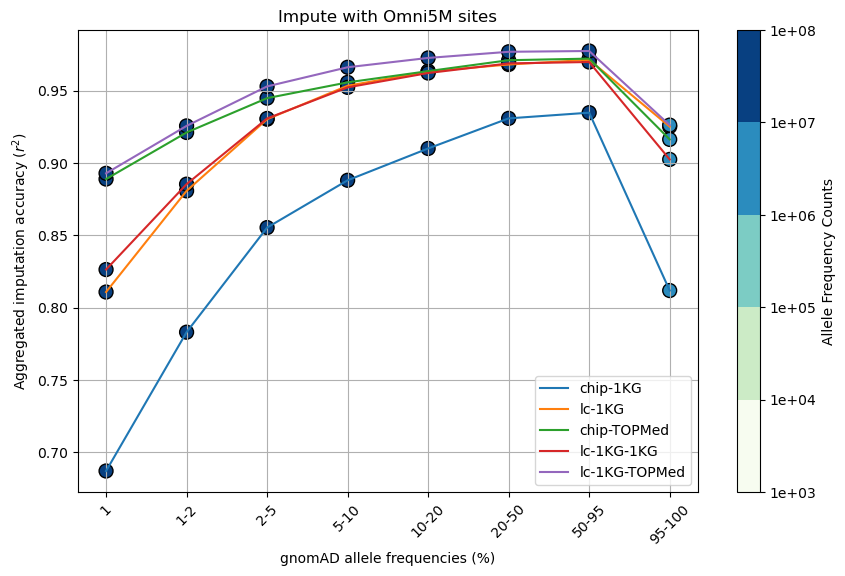

In [25]:
ixs = [2,3,4,5,6]
dfs = [impaccs[i] for i in ixs]
labels = ['chip-1KG', 'lc-1KG', 'chip-TOPMed', 'lc-1KG-1KG', 'lc-1KG-TOPMed']
title = 'Impute with Omni5M sites'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

# Plot FV-mini

In [5]:
mini_impaccs = []
mini_imp_dirs = data['mini_imputation_dir']
for d in mini_imp_dirs:
    v = pd.read_csv(d + "impacc/all_samples/by_sample/all.v.impacc.tsv", sep = '\t')
    mini_impaccs.append(v)

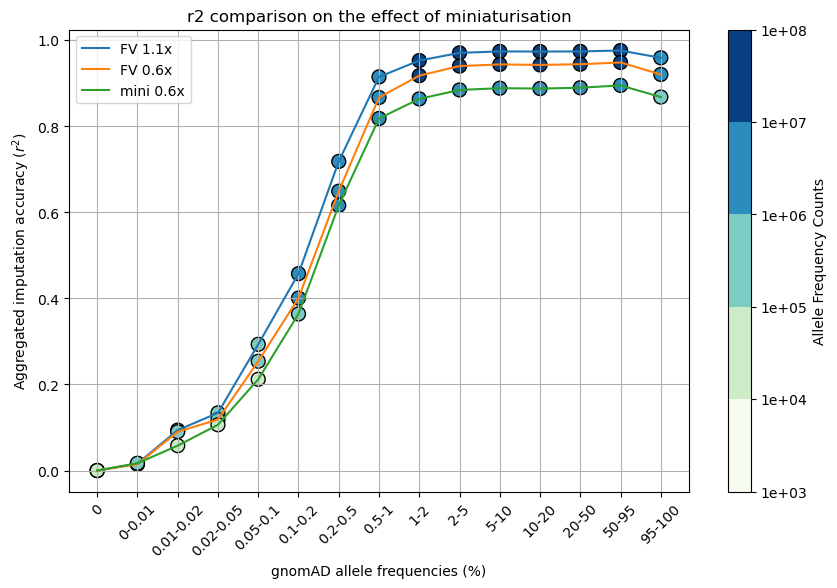

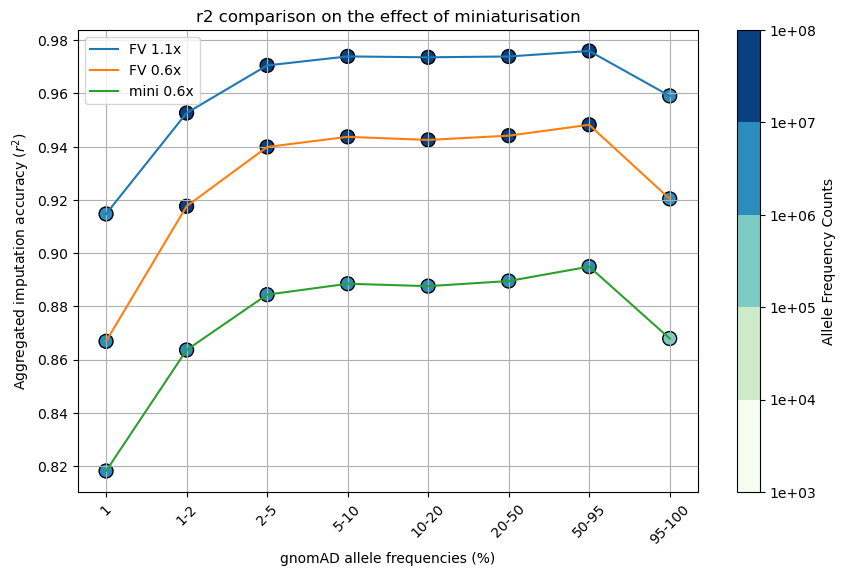

In [15]:
dfs = [impaccs[0]] + [mini_impaccs[0]] + [mini_impaccs[3]]
labels = ['FV 1.1x', 'FV 0.6x', 'mini 0.6x']
title = 'r2 comparison on the effect of miniaturisation'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

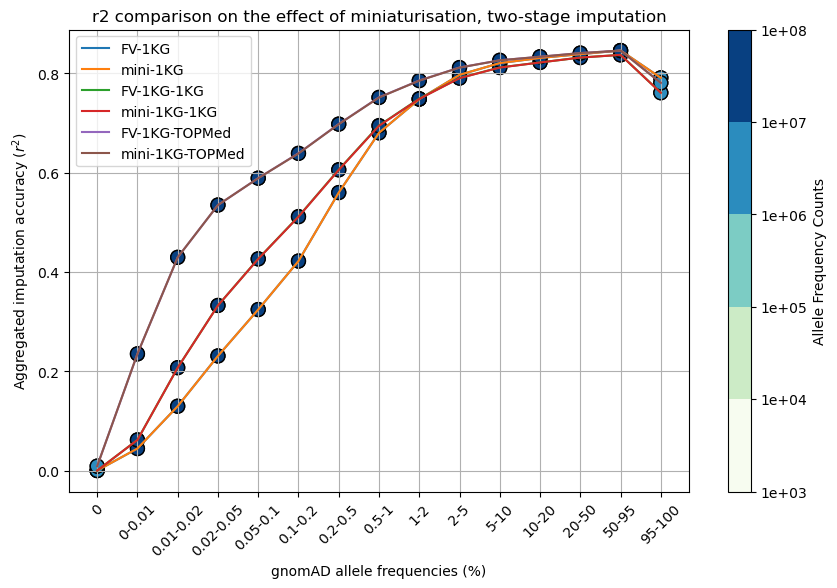

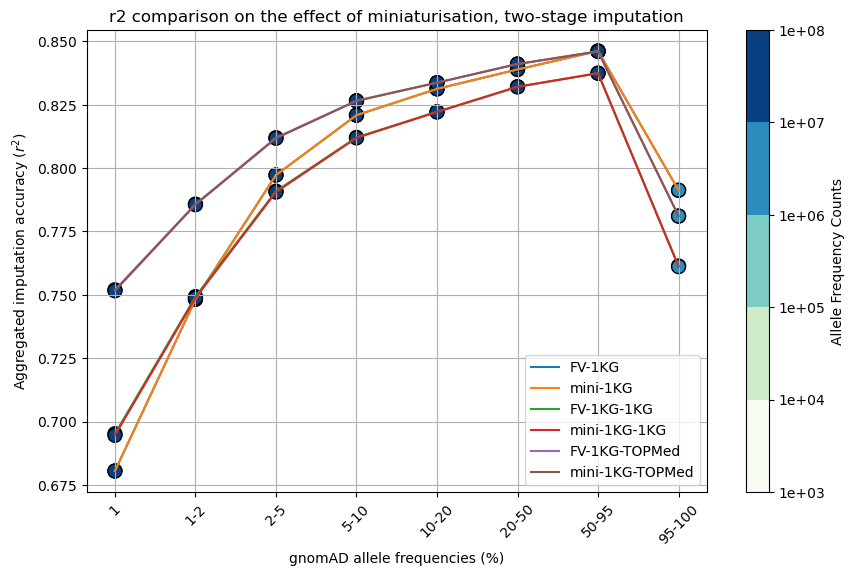

In [16]:
ixs = [2,5,6,7,8,9]
dfs = [mini_impaccs[i] for i in ixs]
labels = ['FV-1KG', 'mini-1KG', 'FV-1KG-1KG', 'mini-1KG-1KG', 'FV-1KG-TOPMed', 'mini-1KG-TOPMed']
title = 'r2 comparison on the effect of miniaturisation, two-stage imputation'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

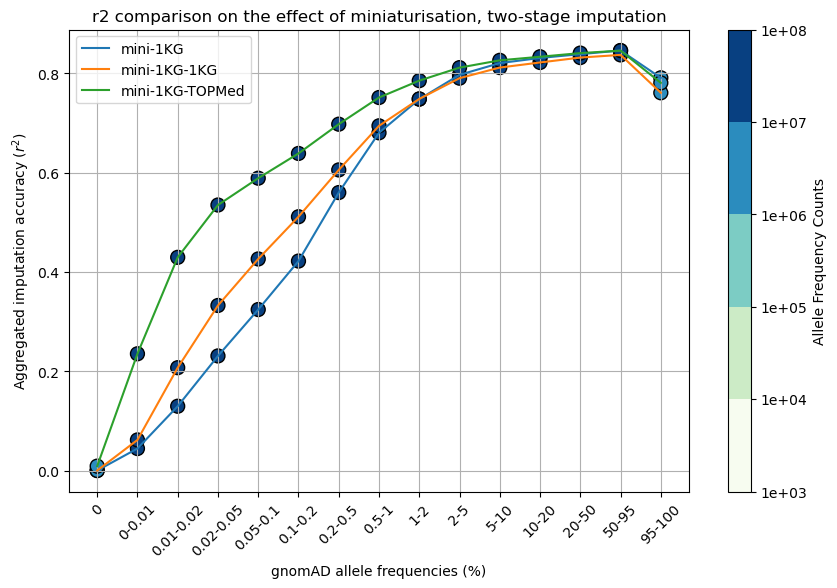

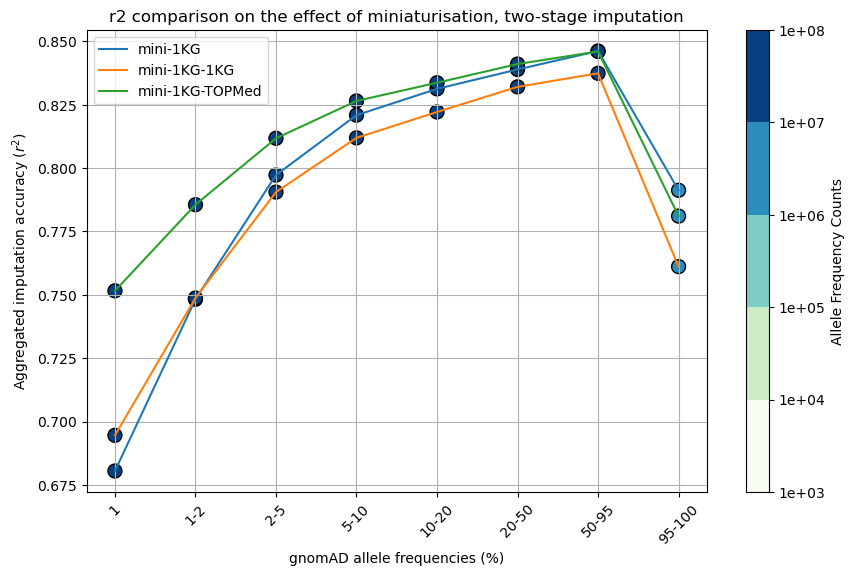

In [63]:
ixs = [5,7,9]
dfs = [mini_impaccs[i] for i in ixs]
labels = ['mini-1KG', 'mini-1KG-1KG', 'mini-1KG-TOPMed']
title = 'r2 comparison on the effect of miniaturisation, two-stage imputation'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

# Plot long-read simulation

In [2]:
rls = ['1kb', '2kb', '5kb', '10kb', '20kb']

chrs = [pd.read_csv("/well/band/users/rbx225/GAMCC/results/imputation_comparison/lr_simulation/lc_oneKG--hc--snps_gw/impacc/all_samples/by_sample/chr" + i + ".v.tsv", sep = '\t') for i in CHROMOSOMES_ALL]
chrs[0]

lr_impaccs = []
res_ary = []
for r in rls:
    for df in chrs:
        lr_impaccs.append(df[df['sample'] == r].drop(columns = 'sample'))
    res_ary.append(lcwgsus.average_impacc_by_chr(lr_impaccs))

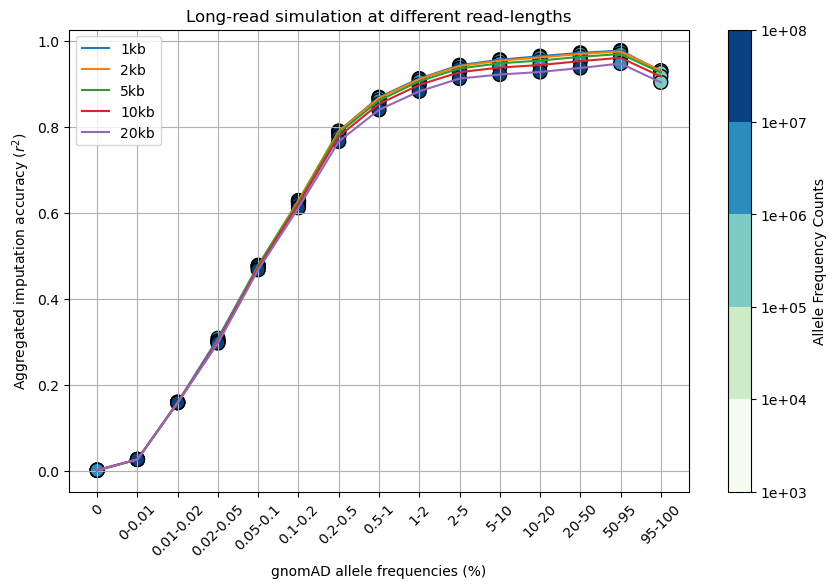

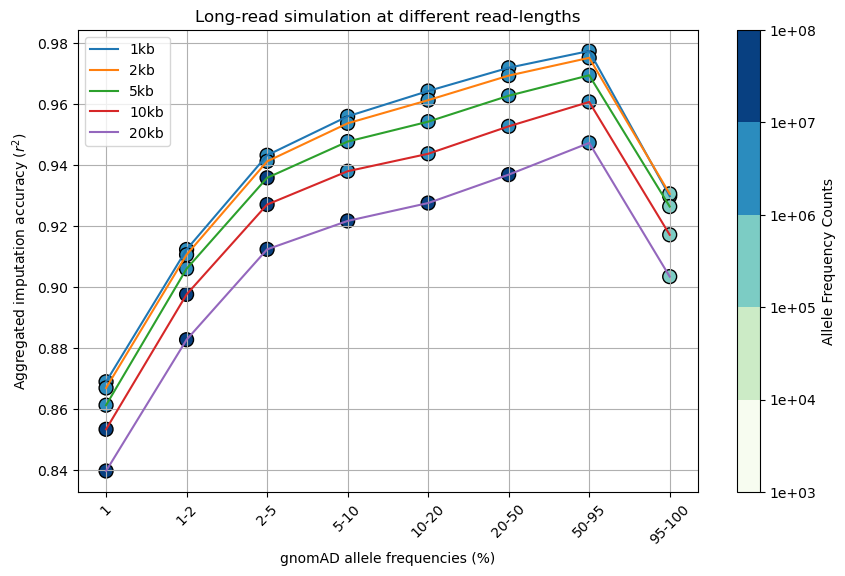

In [39]:
dfs = res_ary
labels = rls
title = 'Long-read simulation at different read-lengths'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

In [7]:
sr = pd.read_csv("results/imputation_comparison/vanilla/lc_oneKG--hc--snps_gw/impacc/all_samples/by_sample/all.v.impacc.tsv", sep = '\t')

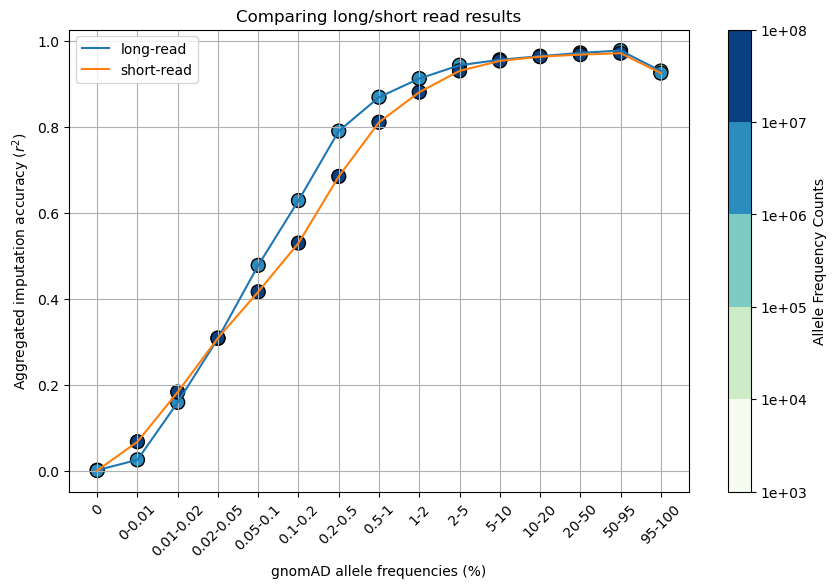

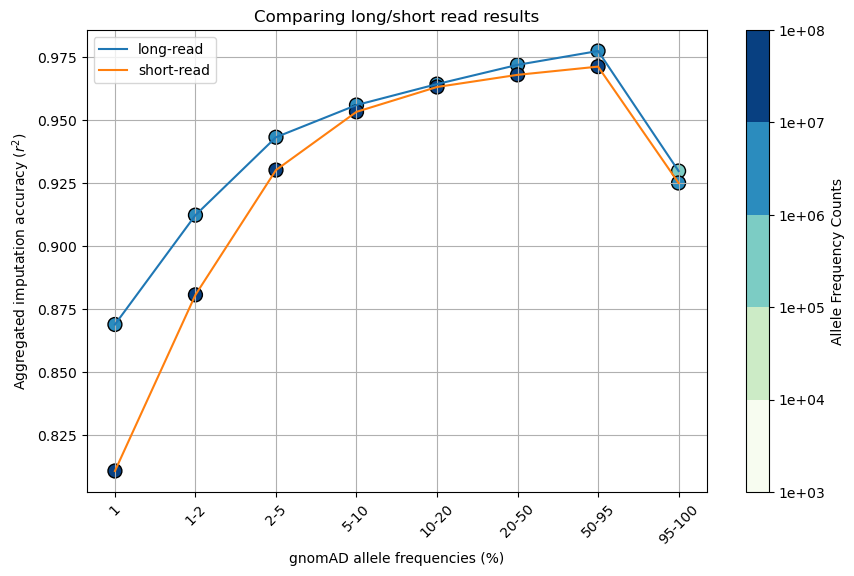

In [6]:
dfs = [res_ary[0], sr]
labels = ['long-read', 'short-read']
title = 'Comparing long/short read results'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

# Plot chip-typed variants by cc and eth

In [114]:
configfile = "/well/band/users/rbx225/GAMCC/pipelines/config.json"
with open(configfile, 'r') as file:
    data = json.load(file)
imp_dirs = data['imputation_dir'][1]

case_controls = ['non-malaria_control', 'mild_malaria', 'severe_malaria']
ethnicities = ['fula', 'jola', 'mandinka', 'wollof']

mini = False
common_cols = ['chr', 'pos', 'ref', 'alt']
lc_sample_prefix = 'GM'
chip_sample_prefix = 'GAM'
seq_sample_prefix = 'IDT'
imp_dir = imp_dirs

sample_linker='data/metadata/sample_linker.csv'
# sample_linker = pd.read_csv(sample_linker)

chromosomes = [str(i) for i in range(1,23)]
impaccs = []

d = "/well/band/users/rbx225/GAMCC/results/imputation_comparison/oneKG/lc_chip_typed_high_info/impacc/by_eth/by_sample/"

for e in ethnicities:
    v_lst = [d + e + ".chr" + i + ".v.impacc.tsv" for i in chromosomes]
    v_dfs = [pd.read_csv(i, sep = '\t') for i in v_lst]
    v = lcwgsus.average_impacc_by_chr(v_dfs)
    impaccs.append(v)

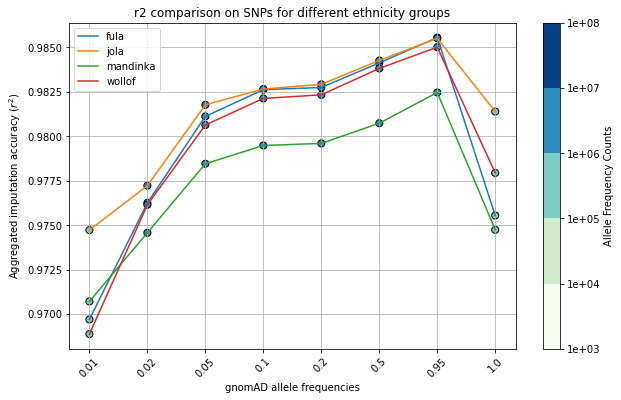

In [119]:
labels = ethnicities
dfs = [df[['AF', 'r2', 'r2_AC']] for df in impaccs]
t = 0.01
title = 'r2 comparison on SNPs for different ethnicity groups'

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
plt.grid(False)

cmap = plt.get_cmap('GnBu')
magnitude = 5
bounds = np.logspace(3, 8, magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

for i in range(len(dfs)):
    triplet = dfs[i][dfs[i]['AF'] >= t]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = triplet[c0]
    vals = triplet[c1]
    color = triplet[c2]

    plt.plot(x, vals, label = label)
    plt.xticks(x, afs, rotation = 45)

    im = ax.scatter(x, vals, c=color, edgecolor='black', cmap=cmap, norm=norm, s = 50)
plt.colorbar(im, boundaries=bounds, ticks = bounds, format=FuncFormatter(fmt), label='Allele Frequency Counts')

plt.xlabel('gnomAD allele frequencies')
plt.title(title)
plt.legend()
plt.ylabel('Aggregated imputation accuracy ($r^2$)')
ax = plt.gca()
ax.grid()

In [120]:
configfile = "/well/band/users/rbx225/GAMCC/pipelines/config.json"
with open(configfile, 'r') as file:
    data = json.load(file)
imp_dirs = data['imputation_dir'][1]

case_controls = ['non-malaria_control', 'mild_malaria', 'severe_malaria']
ethnicities = ['fula', 'jola', 'mandinka', 'wollof']

mini = False
common_cols = ['chr', 'pos', 'ref', 'alt']
lc_sample_prefix = 'GM'
chip_sample_prefix = 'GAM'
seq_sample_prefix = 'IDT'
imp_dir = imp_dirs

sample_linker='data/metadata/sample_linker.csv'
# sample_linker = pd.read_csv(sample_linker)

chromosomes = [str(i) for i in range(1,23)]
impaccs = []

d = "/well/band/users/rbx225/GAMCC/results/imputation_comparison/oneKG/lc_chip_typed_high_info/impacc/by_cc/by_sample/"

for c in case_controls:
    v_lst = [d + c + ".chr" + i + ".v.impacc.tsv" for i in chromosomes]
    v_dfs = [pd.read_csv(i, sep = '\t') for i in v_lst]
    v = lcwgsus.average_impacc_by_chr(v_dfs)
    impaccs.append(v)

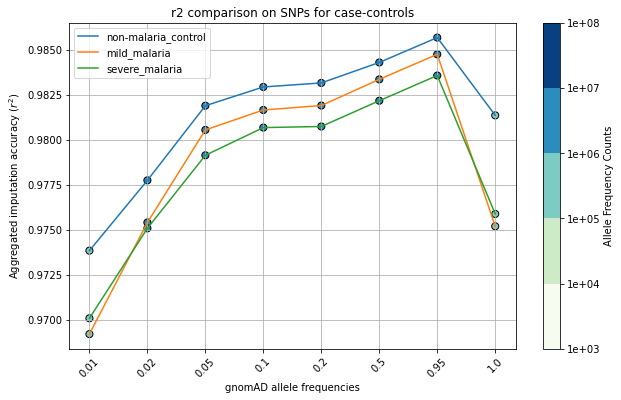

In [122]:
labels = case_controls
dfs = [df[['AF', 'r2', 'r2_AC']] for df in impaccs]
t = 0.01
title = 'r2 comparison on SNPs for case-controls'

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
plt.grid(False)

cmap = plt.get_cmap('GnBu')
magnitude = 5
bounds = np.logspace(3, 8, magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

for i in range(len(dfs)):
    triplet = dfs[i][dfs[i]['AF'] >= t]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = triplet[c0]
    vals = triplet[c1]
    color = triplet[c2]

    plt.plot(x, vals, label = label)
    plt.xticks(x, afs, rotation = 45)

    im = ax.scatter(x, vals, c=color, edgecolor='black', cmap=cmap, norm=norm, s = 50)
plt.colorbar(im, boundaries=bounds, ticks = bounds, format=FuncFormatter(fmt), label='Allele Frequency Counts')

plt.xlabel('gnomAD allele frequencies')
plt.title(title)
plt.legend()
plt.ylabel('Aggregated imputation accuracy ($r^2$)')
ax = plt.gca()
ax.grid()